# Luisa Johanna Kaczmarek
#### Student ID: 16242

#### City chosen for analysis: Chicago
#### Data range of historical data: January 2023 – December 2023

> **Sessions 7 & 8** — Stationarity Testing, Autocorrelation Analysis, Comparative City Analysis & Forecasting Models
> Builds directly on Session 6 (classical decomposition, multi-seasonality, anomaly research).

# 0) Read Timeseries Data

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the daily trip count series produced in Session 6
daily_trips = pd.read_parquet(
    "/content/drive/MyDrive/emerging_topics_session_5/data/daily_trips.parquet"
)['trips']

print(f"Series loaded: {len(daily_trips)} days")
print(f"Date range:    {daily_trips.index.min().date()} → {daily_trips.index.max().date()}")
print(f"Mean:          {daily_trips.mean():.1f} trips/day")
print(f"Std dev:       {daily_trips.std():.1f}")

Series loaded: 365 days
Date range:    2023-01-01 → 2023-12-31
Mean:          15670.9 trips/day
Std dev:       8234.6


# 1) Visual Inspection with Rolling Statistics

Overall mean:    15670.90
Overall std dev: 8234.64


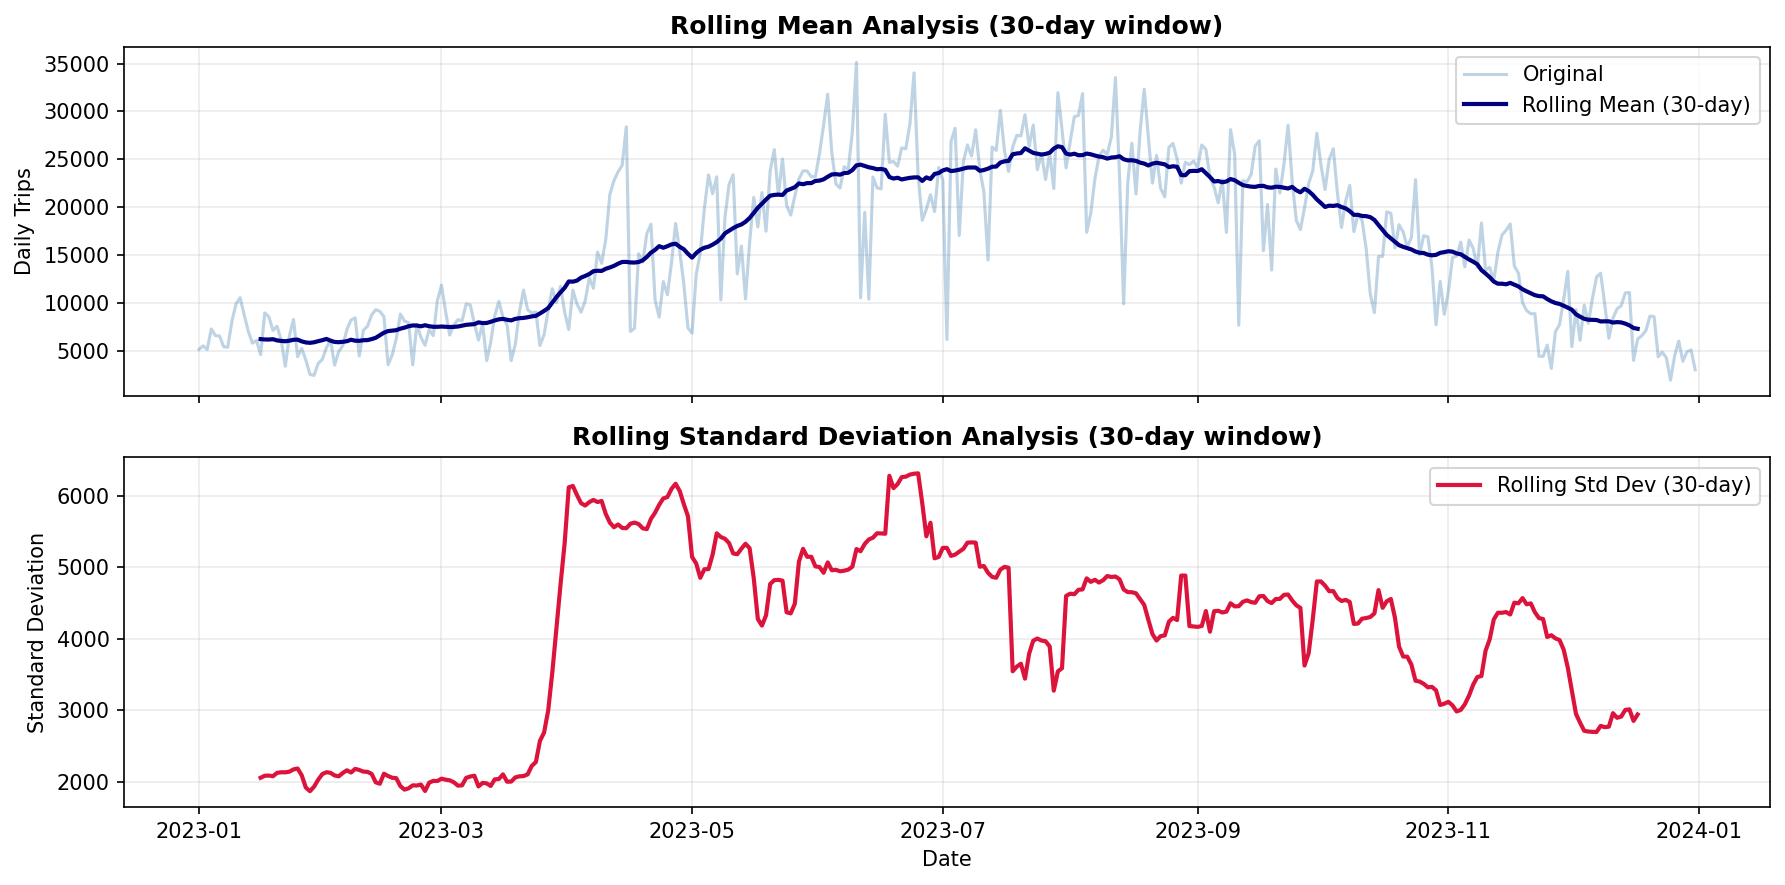

In [40]:
# Rolling statistics — 30-day window
rolling_mean = daily_trips.rolling(window=30, center=True).mean()
rolling_std  = daily_trips.rolling(window=30, center=True).std()

print(f"Overall mean:    {daily_trips.mean():.2f}")
print(f"Overall std dev: {daily_trips.std():.2f}")

fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=150, sharex=True)

axes[0].plot(daily_trips.index, daily_trips.values, alpha=0.35, color='steelblue', label='Original')
axes[0].plot(rolling_mean.index, rolling_mean.values, linewidth=2, color='navy', label='Rolling Mean (30-day)')
axes[0].set_title('Rolling Mean Analysis (30-day window)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Daily Trips')
axes[0].grid(True, alpha=0.25)
axes[0].legend()

axes[1].plot(rolling_std.index, rolling_std.values, linewidth=2, color='crimson', label='Rolling Std Dev (30-day)')
axes[1].set_title('Rolling Standard Deviation Analysis (30-day window)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.25)
axes[1].legend()

plt.tight_layout()
plt.show()

**Insights:**
- **Strong non-stationary mean:** Rolling mean rises steadily from winter to summer, then declines sharply — confirms the annual trend from Session 6 decomposition
- **Peak demand mid-year:** Highest rolling mean around June–August, consistent with August peak (≈24,893 avg trips) found in Session 6
- **Volatility is time-varying:** Rolling std is low in winter, increases sharply from April — the heteroskedasticity flagged in Session 6 residuals
- **Declining volatility toward winter:** End-of-year demand is both lower and more predictable
- **Modelling implication:** Series is non-stationary in **both mean and variance** → differencing + Box-Cox (λ ≈ 0.55) required

## Quantitative assessment

In [41]:
print(f"Rolling mean  — min: {rolling_mean.min():.0f},  max: {rolling_mean.max():.0f}")
print(f"Rolling mean  — absolute range: {rolling_mean.max() - rolling_mean.min():.0f} trips")

mean_variation_pct = (rolling_mean.max() - rolling_mean.min()) / daily_trips.mean() * 100
print(f"Rolling mean  — range as % of overall mean: {mean_variation_pct:.1f}%")
print()
print(f"Rolling std dev — min: {rolling_std.min():.0f},  max: {rolling_std.max():.0f}")
print(f"Rolling std dev — volatility increase factor: {rolling_std.max()/rolling_std.min():.1f}×")

Rolling mean  — min: 5819,  max: 26356
Rolling mean  — absolute range: 20538 trips
Rolling mean  — range as % of overall mean: 131.1%

Rolling std dev — min: 1868,  max: 6313
Rolling std dev — volatility increase factor: 3.4×


**Key numbers:**
- Rolling mean range: min ≈ **5,819**, max ≈ **26,356** — absolute change ≈ **20,538 trips**, larger than the overall mean (≈ 15,671)
- Mean variation ≈ **131%** of the overall mean → decisive evidence against mean stationarity
- Std dev range: **~1,868 → ~6,313** — volatility increases **~3.4×** from winter to summer (heteroskedasticity)
- Simple ARMA on raw levels would be inappropriate

# 2) ADF Test — Formal Stationarity Check

The Augmented Dickey-Fuller test checks for a unit root.
- **H₀:** Series has a unit root (non-stationary)
- **H₁:** Series is stationary
- Reject H₀ if p-value < 0.05

In [42]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_trips.dropna(), autolag='AIC')
adf_statistic   = result[0]
p_value         = result[1]
n_lags          = result[2]
n_obs           = result[3]
critical_values = result[4]

print(f"ADF Statistic:     {adf_statistic:.4f}")
print(f"P-value:           {p_value:.6f}")
print(f"Lags used (AIC):   {n_lags}")
print(f"Observations:      {n_obs}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"  {k}: {float(v):.4f}")

ADF Statistic:     -0.8923
P-value:           0.790485
Lags used (AIC):   13
Observations:      351
Critical values:
  1%: -3.4491
  5%: -2.8698
  10%: -2.5712


**Interpretation:**
- ADF statistic ≈ **−0.89**, well above all critical values (−2.87 at 5%)
- p-value ≈ **0.79** >> 0.05 → **fail to reject H₀**
- **Conclusion: the raw series has a unit root and is NOT stationary**
- Consistent with the Session 6 trend component; AIC selected 13 lags to account for weekly structure

# 3) Differencing & Retesting

Since the series is non-stationary, we apply **first-order differencing** (d=1): Δyₜ = yₜ − yₜ₋₁, removing the trend. We then retest.

In [43]:
daily_trips_diff = daily_trips.diff().dropna()

**Plot & retest**

Overall mean:    -5.87
Overall std dev: 4551.74


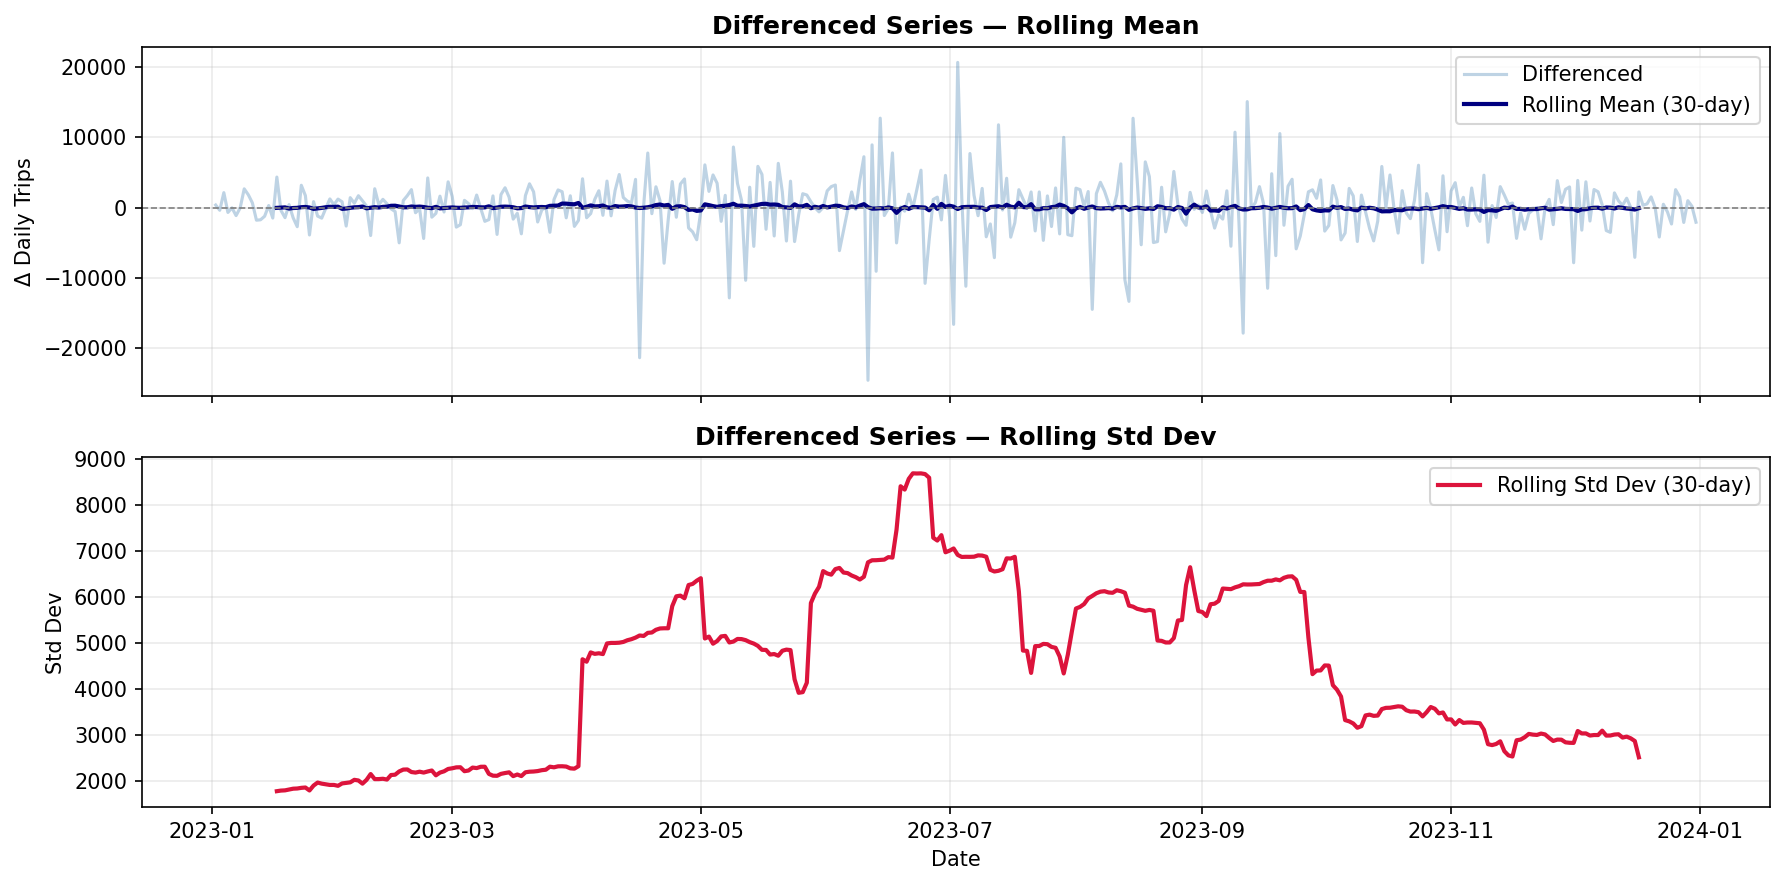

In [44]:
rolling_mean_d = daily_trips_diff.rolling(window=30, center=True).mean()
rolling_std_d  = daily_trips_diff.rolling(window=30, center=True).std()

print(f"Overall mean:    {daily_trips_diff.mean():.2f}")
print(f"Overall std dev: {daily_trips_diff.std():.2f}")

fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=150, sharex=True)

axes[0].plot(daily_trips_diff.index, daily_trips_diff.values, alpha=0.35, color='steelblue', label='Differenced')
axes[0].plot(rolling_mean_d.index, rolling_mean_d.values, linewidth=2, color='navy', label='Rolling Mean (30-day)')
axes[0].axhline(0, color='grey', linestyle='--', linewidth=0.8)
axes[0].set_title('Differenced Series — Rolling Mean', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Δ Daily Trips')
axes[0].grid(True, alpha=0.25)
axes[0].legend()

axes[1].plot(rolling_std_d.index, rolling_std_d.values, linewidth=2, color='crimson', label='Rolling Std Dev (30-day)')
axes[1].set_title('Differenced Series — Rolling Std Dev', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Std Dev')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.25)
axes[1].legend()

plt.tight_layout()
plt.show()

**Repeat ADF-test**

In [45]:
result_d = adfuller(daily_trips_diff.dropna(), autolag='AIC')
adf_statistic   = result_d[0]
p_value         = result_d[1]
n_lags          = result_d[2]
n_obs           = result_d[3]
critical_values = result_d[4]

print(f"ADF Statistic:     {adf_statistic:.4f}")
print(f"P-value:           {p_value:.2e}")
print(f"Lags used (AIC):   {n_lags}")
print(f"Observations:      {n_obs}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"  {k}: {float(v):.4f}")

ADF Statistic:     -8.5360
P-value:           1.01e-13
Lags used (AIC):   12
Observations:      351
Critical values:
  1%: -3.4491
  5%: -2.8698
  10%: -2.5712


- p-value ≈ **1.0 × 10⁻¹³** — far below any conventional significance level
- **H₀ decisively rejected → differenced series is stationary**
- First differencing (d=1) successfully removes non-stationarity in the mean
- AIC selected 12 lags — reasonable for daily data with weekly structure
- Time-varying variance remains; a Box-Cox transform before model fitting would stabilise it

# 4) Autocorrelation Analysis

We analyse the **differenced series** (stationary) to determine the ARIMA order.
- **ACF** → guides MA(q) order
- **PACF** → guides AR(p) order

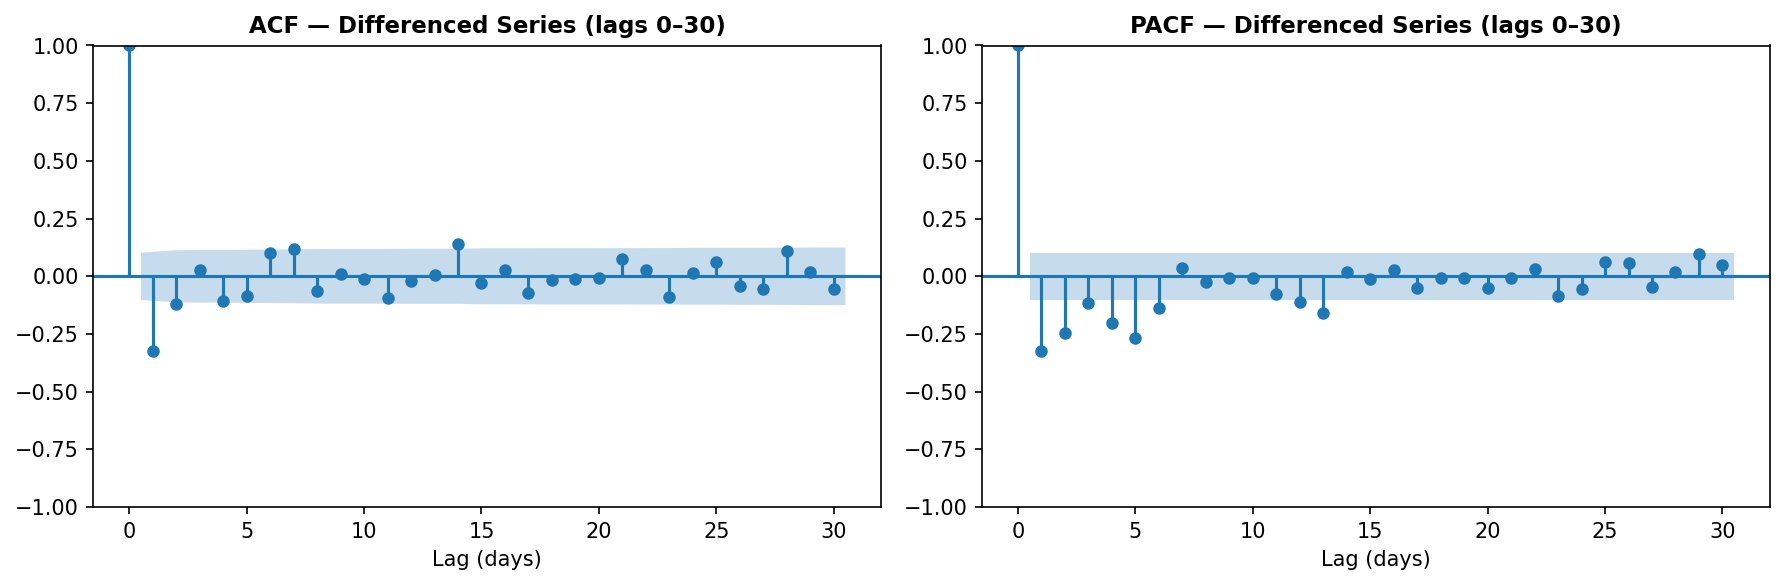

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

plot_acf(daily_trips_diff.dropna(), lags=30, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF — Differenced Series (lags 0–30)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Lag (days)')

plot_pacf(daily_trips_diff.dropna(), lags=30, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF — Differenced Series (lags 0–30)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Lag (days)')

plt.tight_layout()
plt.show()

**Check which autocorrelations are significant**

In [47]:
from statsmodels.tsa.stattools import acf, pacf

x = daily_trips_diff.dropna()
n = len(x)
ci_thr = 1.96 / np.sqrt(n)

acf_values,  acf_confint  = acf(x,  nlags=30, alpha=0.05, fft=True)
pacf_values, pacf_confint = pacf(x, nlags=30, alpha=0.05, method='ywm')

def stars(ci_low, ci_high):
    return '***' if (ci_low > 0) or (ci_high < 0) else ''

acf_rows, pacf_rows = [], []
for lag in range(1, len(acf_values)):
    lo, hi = acf_confint[lag]
    acf_rows.append([lag, acf_values[lag], stars(lo, hi)])
for lag in range(1, len(pacf_values)):
    lo, hi = pacf_confint[lag]
    pacf_rows.append([lag, pacf_values[lag], stars(lo, hi)])

acf_df  = pd.DataFrame(acf_rows,  columns=['Lag', 'Autocorr',    'Significant'])
pacf_df = pd.DataFrame(pacf_rows, columns=['Lag', 'Partial Corr','Significant'])

print("SIGNIFICANT AUTOCORRELATIONS (ACF)")
sig = acf_df[acf_df['Significant'] == '***']
print(sig.to_string(index=False, formatters={'Autocorr': '{:.4f}'.format}) if len(sig) else '(none)')

print("\nSIGNIFICANT PARTIAL AUTOCORRELATIONS (PACF)")
sig = pacf_df[pacf_df['Significant'] == '***']
print(sig.to_string(index=False, formatters={'Partial Corr': '{:.4f}'.format}) if len(sig) else '(none)')

print(f"\n95% CI threshold: ±{ci_thr:.4f}  (n = {n})")
print("\nKEY LAG CORRELATIONS:")
print("-" * 35)
for lag in [1, 7, 14, 21, 28]:
    if lag < len(acf_values):
        print(f"ACF  (lag {lag:>2}): {acf_values[lag]: .4f}  {'***' if abs(acf_values[lag]) > ci_thr else ''}")
        print(f"PACF (lag {lag:>2}): {pacf_values[lag]: .4f}  {'***' if abs(pacf_values[lag]) > ci_thr else ''}")

SIGNIFICANT AUTOCORRELATIONS (ACF)
 Lag Autocorr Significant
   1  -0.3216         ***
   2  -0.1186         ***
   7   0.1195         ***
  14   0.1412         ***

SIGNIFICANT PARTIAL AUTOCORRELATIONS (PACF)
 Lag Partial Corr Significant
   1      -0.3216         ***
   2      -0.2477         ***
   3      -0.1175         ***
   4      -0.2012         ***
   5      -0.2676         ***
   6      -0.1371         ***
  12      -0.1096         ***
  13      -0.1588         ***

95% CI threshold: ±0.1027  (n = 364)

KEY LAG CORRELATIONS:
-----------------------------------
ACF  (lag  1): -0.3216  ***
PACF (lag  1): -0.3216  ***
ACF  (lag  7):  0.1195  ***
PACF (lag  7):  0.0364  
ACF  (lag 14):  0.1412  ***
PACF (lag 14):  0.0196  
ACF  (lag 21):  0.0760  
PACF (lag 21): -0.0059  
ACF  (lag 28):  0.1081  ***
PACF (lag 28):  0.0172  


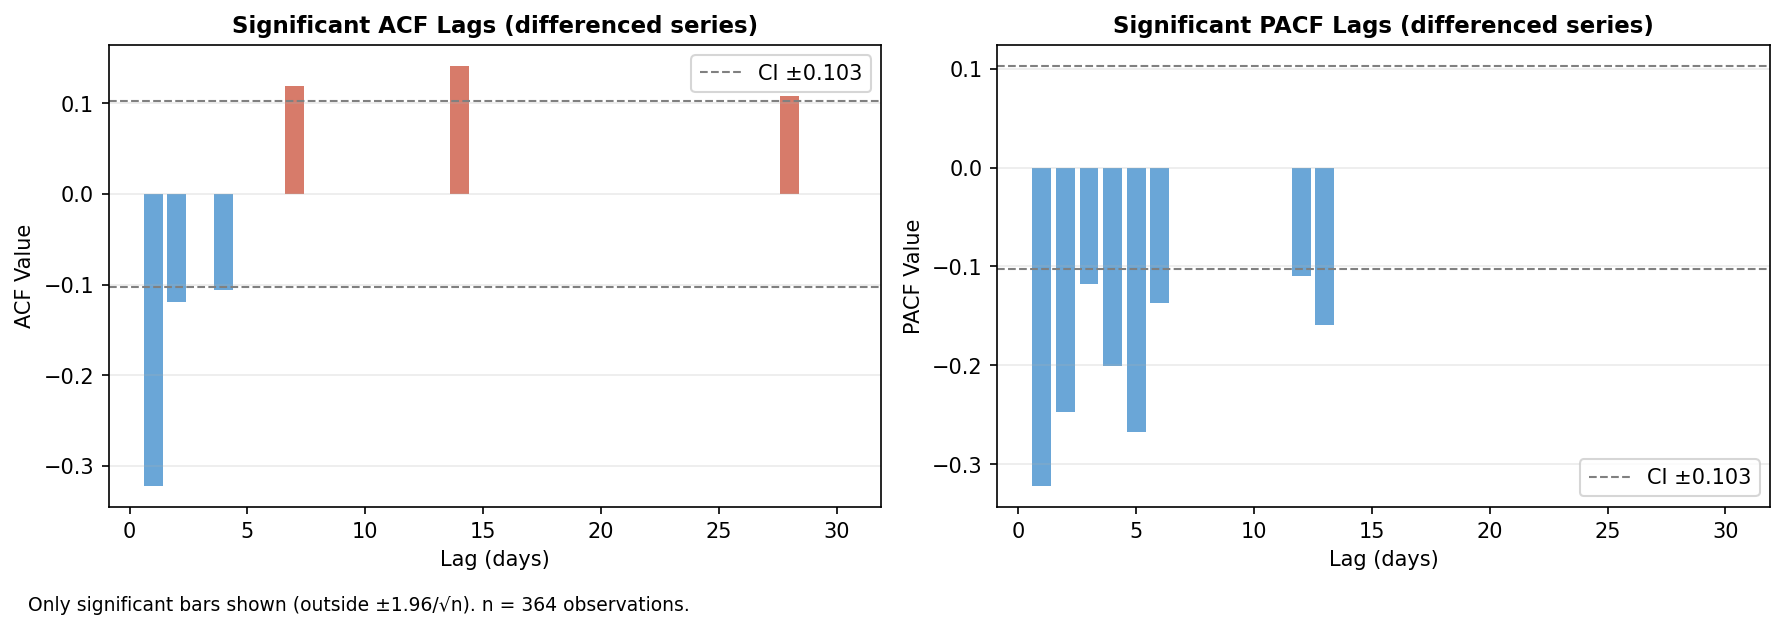

In [48]:
acf_lags  = np.arange(1, len(acf_values))
pacf_lags = np.arange(1, len(pacf_values))
acf_plot  = acf_values[1:]
pacf_plot = pacf_values[1:]
acf_sig   = np.abs(acf_plot)  > ci_thr
pacf_sig  = np.abs(pacf_plot) > ci_thr

acf_h  = np.where(acf_sig,  acf_plot,  0.0)
pacf_h = np.where(pacf_sig, pacf_plot, 0.0)
acf_colors  = np.where(acf_plot  >= 0, '#d77b6a', '#6aa6d7')
pacf_colors = np.where(pacf_plot >= 0, '#d77b6a', '#6aa6d7')

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

axes[0].bar(acf_lags, acf_h, color=acf_colors, edgecolor='none')
axes[0].axhline( ci_thr, linestyle='--', linewidth=1, color='grey', label=f'CI ±{ci_thr:.3f}')
axes[0].axhline(-ci_thr, linestyle='--', linewidth=1, color='grey')
axes[0].set_title('Significant ACF Lags (differenced series)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Lag (days)')
axes[0].set_ylabel('ACF Value')
axes[0].grid(axis='y', alpha=0.25)
axes[0].legend()

axes[1].bar(pacf_lags, pacf_h, color=pacf_colors, edgecolor='none')
axes[1].axhline( ci_thr, linestyle='--', linewidth=1, color='grey', label=f'CI ±{ci_thr:.3f}')
axes[1].axhline(-ci_thr, linestyle='--', linewidth=1, color='grey')
axes[1].set_title('Significant PACF Lags (differenced series)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('PACF Value')
axes[1].grid(axis='y', alpha=0.25)
axes[1].legend()

fig.text(0.02, -0.03,
    f"Only significant bars shown (outside ±1.96/√n). n = {n} observations.",
    fontsize=9)

plt.tight_layout()
plt.show()

**Interpretation — differenced series:**

**ACF:**
- Strong **negative spike at lag 1** → short-run MA effect
- Smaller negatives at lags 2–4 → damped, not persistent
- **Positive spikes at lags 7 and 14** → weekly seasonality **still present** after simple differencing —
- This residual weekly signal is important: it confirms SARIMA (not plain ARIMA) is required

**PACF:**
- Significant at lags 1–6, tailing off → MA-type dominance, not pure AR
- No sharp AR cutoff

**Model implications:**
- d=1 achieves mean stationarity but does **not** eliminate weekly autocorrelation
- Supports **SARIMA(0,1,1)(1,0,0)[7]** — non-seasonal MA(1) + seasonal AR(1) to absorb the lag-7 signal
- Box-Cox transform (λ ≈ 0.55 from Session 6) recommended before fitting to address heteroskedasticity

### Conclusion: Models to try

- **SARIMA** is appropriate — data has strong weekly seasonality confirmed by ACF/PACF
- **Degree of differencing:** d=1 (simple first difference) renders the series stationary in the mean
- **Seasonal differencing (D):** With lag-7 signal still present after d=1, adding D=1 (seasonal differencing at s=7) is an alternative worth testing; without it, include SAR(1) or SMA(1) terms

Seasonal (weekly, s = 7) — recommended starting point:
- **SARIMA(0,1,1)(1,0,0)[7]**

# Session 7 Extra: Comparative City Analysis

We load the 2023 Capital Bikeshare data for Washington D.C. to compare seasonal patterns and decomposition structure with Chicago Divvy 2023.


In [49]:
import pandas as pd
import requests
import zipfile
import io
import os

def load_capital_bikeshare_2023_data():
    base_url = "https://s3.amazonaws.com/capitalbikeshare-data/"
    all_data_frames = []

    for month in range(1, 13):
        month_str = str(month).zfill(2)
        file_name = f"2023{month_str}-capitalbikeshare-tripdata.zip"
        url = base_url + file_name
        print(f"Downloading {file_name}...")

        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()

            with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
                csv_file_name = [name for name in zf.namelist() if name.endswith('.csv')][0]
                with zf.open(csv_file_name) as csv_file:
                    df = pd.read_csv(csv_file, parse_dates=['started_at', 'ended_at'])
                    all_data_frames.append(df)
                    print(f"  Successfully loaded {csv_file_name}.")

        except requests.exceptions.RequestException as e:
            print(f"  Failed to download {file_name}: {e}")
        except zipfile.BadZipFile:
            print(f"  Failed to open {file_name}: Not a valid zip file.")
        except IndexError:
            print(f"  No CSV file found in {file_name}.")
        except Exception as e:
            print(f"  An unexpected error occurred while processing {file_name}: {e}")

    if all_data_frames:
        full_df = pd.concat(all_data_frames, ignore_index=True)
        print(f"\nSuccessfully loaded {len(all_data_frames)} months of 2023 Capital Bikeshare data.")
        print(f"Total rows: {len(full_df):,}")
        return full_df
    else:
        print("No data could be loaded.")
        return pd.DataFrame()

capital_bikeshare_2023_data = load_capital_bikeshare_2023_data()

if not capital_bikeshare_2023_data.empty:
    print("\nFirst 5 rows:")
    print(capital_bikeshare_2023_data.head())
    print("\nData types:")
    print(capital_bikeshare_2023_data.info())

  Successfully loaded 202301-capitalbikeshare-tripdata.csv.
  Successfully loaded 202302-captialbikeshare-tripdata.csv.
  Successfully loaded 202303-capitalbikeshare-tripdata.csv.
  Successfully loaded 202304-capitalbikeshare-tripdata.csv.
  Successfully loaded 202305-capitalbikeshare-tripdata.csv.
  Successfully loaded 202306-capitalbikeshare-tripdata.csv.
  Successfully loaded 202307-capitalbikeshare-tripdata.csv.
  Successfully loaded 202308-capitalbikeshare-tripdata.csv.
  Successfully loaded 202309-capitalbikeshare-tripdata.csv.
  Successfully loaded 202310-capitalbikeshare-tripdata.csv.
  Successfully loaded 202311-capitalbikeshare-tripdata.csv.
  Successfully loaded 202312-capitalbikeshare-tripdata.csv.

Successfully loaded 12 months of 2023 Capital Bikeshare data.
Total rows: 4,467,334

First 5 rows:
            ride_id rideable_type          started_at            ended_at  \
0  65F0ACD101BF0D49  classic_bike 2023-01-04 19:34:07 2023-01-04 19:39:29   
1  D75158CE73DC43F0  class

In [50]:
capital_bikeshare_2023_data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,65F0ACD101BF0D49,classic_bike,2023-01-04 19:34:07,2023-01-04 19:39:29,East Falls Church Metro / Sycamore St & 19th St N,31904.0,W Columbia St & N Washington St,32609.0,38.885321,-77.156427,38.885621,-77.166917,member
1,D75158CE73DC43F0,classic_bike,2023-01-27 15:26:38,2023-01-27 19:21:36,Carroll & Westmoreland Ave,32025.0,Fenton St & Ellsworth Dr,32036.0,38.975000,-77.011210,38.997033,-77.025608,member
2,33E85889625FF7CA,classic_bike,2023-01-05 20:44:38,2023-01-05 20:51:18,15th & L St NW,31276.0,Thomas Circle,31241.0,38.903649,-77.034918,38.905900,-77.032500,member
3,E1F055A1651F47A1,classic_bike,2023-01-03 17:45:14,2023-01-03 17:57:23,Hartland Rd & Harte Pl,32255.0,Merrifield Cinema & Merrifield Town Center,32235.0,38.878601,-77.222808,38.870093,-77.229970,member
4,88CC90CEEC298BAF,classic_bike,2023-01-03 05:18:46,2023-01-03 05:25:50,Merrifield Cinema & Merrifield Town Center,32235.0,Hartland Rd & Harte Pl,32255.0,38.870093,-77.229970,38.878601,-77.222808,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4467329,68A1AA2C614921C4,classic_bike,2023-12-16 00:08:39,2023-12-16 00:16:30,11th & S St NW,31280.0,17th & P St NW,31330.0,38.913601,-77.027115,38.909858,-77.038566,member
4467330,25C0FB40A035EA7C,classic_bike,2023-12-06 18:23:32,2023-12-06 18:27:26,Eastern Market / 7th & North Carolina Ave SE,31610.0,Massachusetts Ave & 6th St NE,31657.0,38.886952,-76.996806,38.892934,-76.998273,member
4467331,969BD21B0E2F499A,electric_bike,2023-12-09 17:47:53,2023-12-09 18:03:16,8th & D St NW,31270.0,16th & R St NW,31282.0,38.894771,-77.023308,38.912652,-77.036278,casual
4467332,DEA9A4BA005B1A26,electric_bike,2023-12-09 18:14:52,2023-12-09 18:25:48,5th & F St NW,31620.0,Lincoln Rd & Seaton Pl NE/Harry Thomas Rec Center,31523.0,38.897282,-77.019359,38.915000,-77.007800,casual


In [51]:
capital_bikeshare_2023_data['started_at'] = pd.to_datetime(capital_bikeshare_2023_data['started_at'])
capital_bikeshare_daily_trips = (
    capital_bikeshare_2023_data
    .set_index('started_at')
    .resample('D')
    .size()
)
capital_bikeshare_daily_trips.name = 'Capital Bikeshare Daily Trips'

print("Capital Bikeshare Daily Trips (first 5 rows):")
print(capital_bikeshare_daily_trips.head())
print("\nCapital Bikeshare Daily Trips (last 5 rows):")
print(capital_bikeshare_daily_trips.tail())

Capital Bikeshare Daily Trips (first 5 rows):
started_at
2023-01-01    6787
2023-01-02    7240
2023-01-03    7559
2023-01-04    7791
2023-01-05    8409
Freq: D, Name: Capital Bikeshare Daily Trips, dtype: int64

Capital Bikeshare Daily Trips (last 5 rows):
started_at
2023-12-27    2580
2023-12-28    7918
2023-12-29    8659
2023-12-30    7594
2023-12-31    7327
Freq: D, Name: Capital Bikeshare Daily Trips, dtype: int64


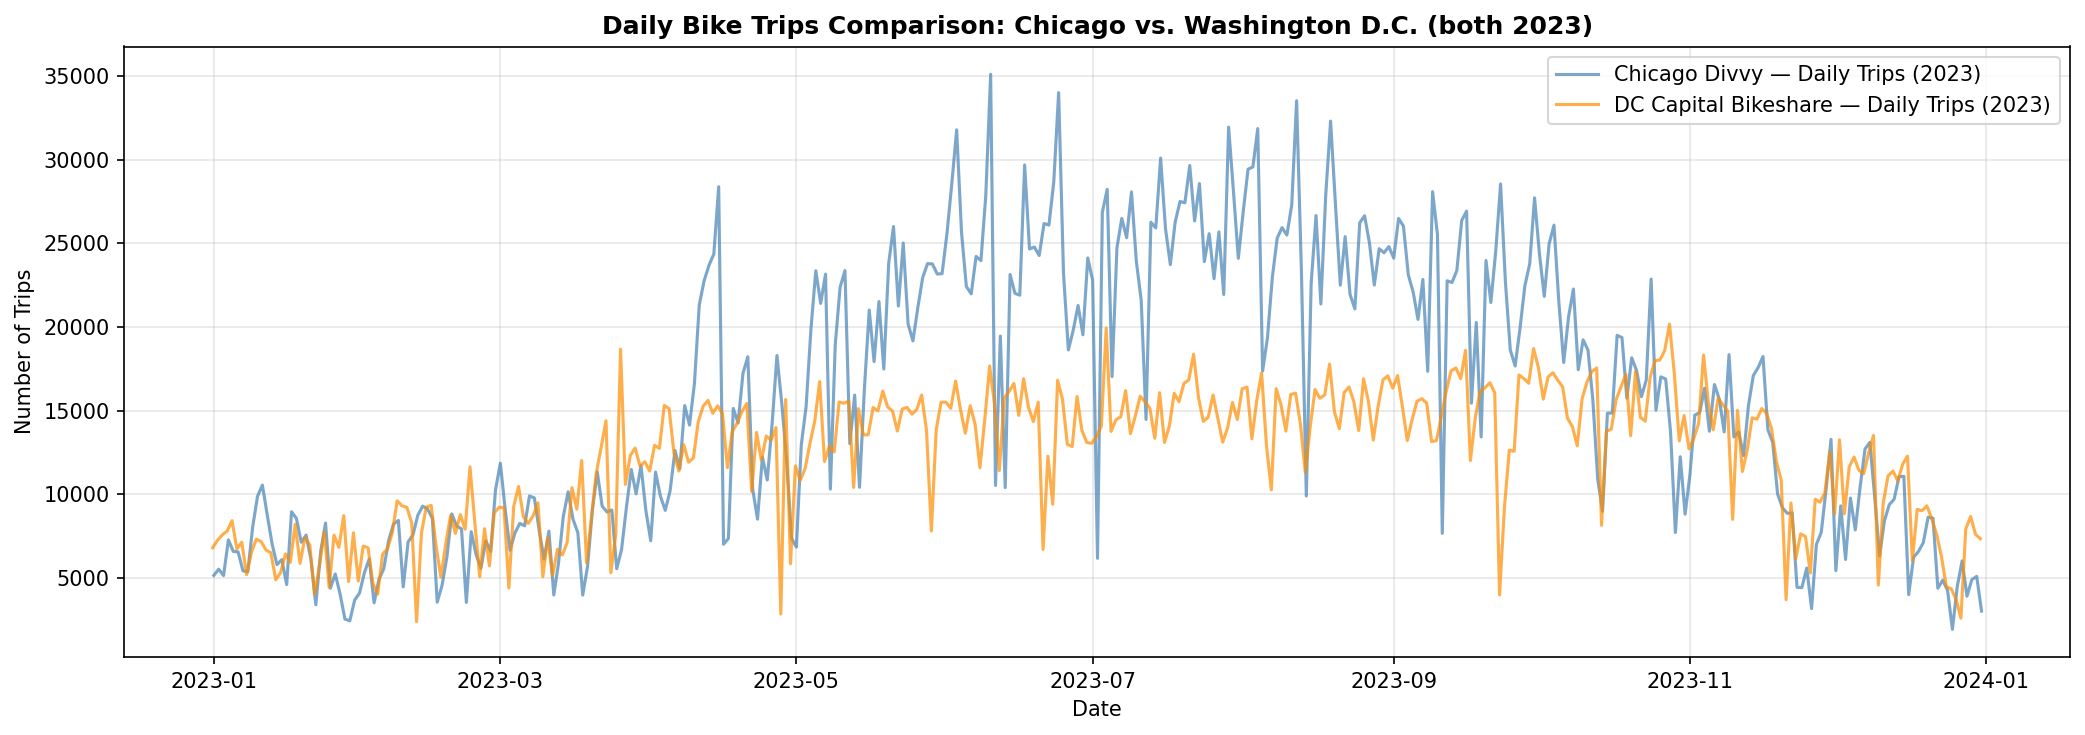

In [52]:
fig, ax = plt.subplots(figsize=(14, 5), dpi=150)

ax.plot(daily_trips.index, daily_trips.values,
        label='Chicago Divvy — Daily Trips (2023)', alpha=0.7, color='steelblue')
ax.plot(capital_bikeshare_daily_trips.index, capital_bikeshare_daily_trips.values,
        label='DC Capital Bikeshare — Daily Trips (2023)', alpha=0.7, color='darkorange')

ax.set_title('Daily Bike Trips Comparison: Chicago vs. Washington D.C. (both 2023)',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Trips')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Insights:**

**Note on timezones:** The DC series (`capital_bikeshare_daily_trips`) is timezone-naive while `daily_trips` (Chicago) has `America/Chicago` timezone. This does not affect the annual comparison plot, but the timezones must be aligned before any joint modelling.

- **Higher peak demand in Chicago:** Chicago peaks at ≈ **24,000–27,000** daily trips in summer. DC peaks at ≈ **15,000–17,000** daily trips
- **Stronger seasonal amplitude in Chicago:** Chicago's winter trough (≈ 5,000–6,000) is proportionally deeper than DC's (≈ 5,000–7,000), giving Chicago a peak-to-trough ratio of ≈ 4× vs. DC's ≈ 2.5×
- **DC has more stable year-round demand:** DC's milder winters and more commuter-oriented usage create a flatter seasonal curve; Chicago is more weather-sensitive and recreation-driven
- **Lower raw volatility in DC:** DC's daily fluctuations are narrower, suggesting a more consistent ridership base (likely more commuter than leisure)

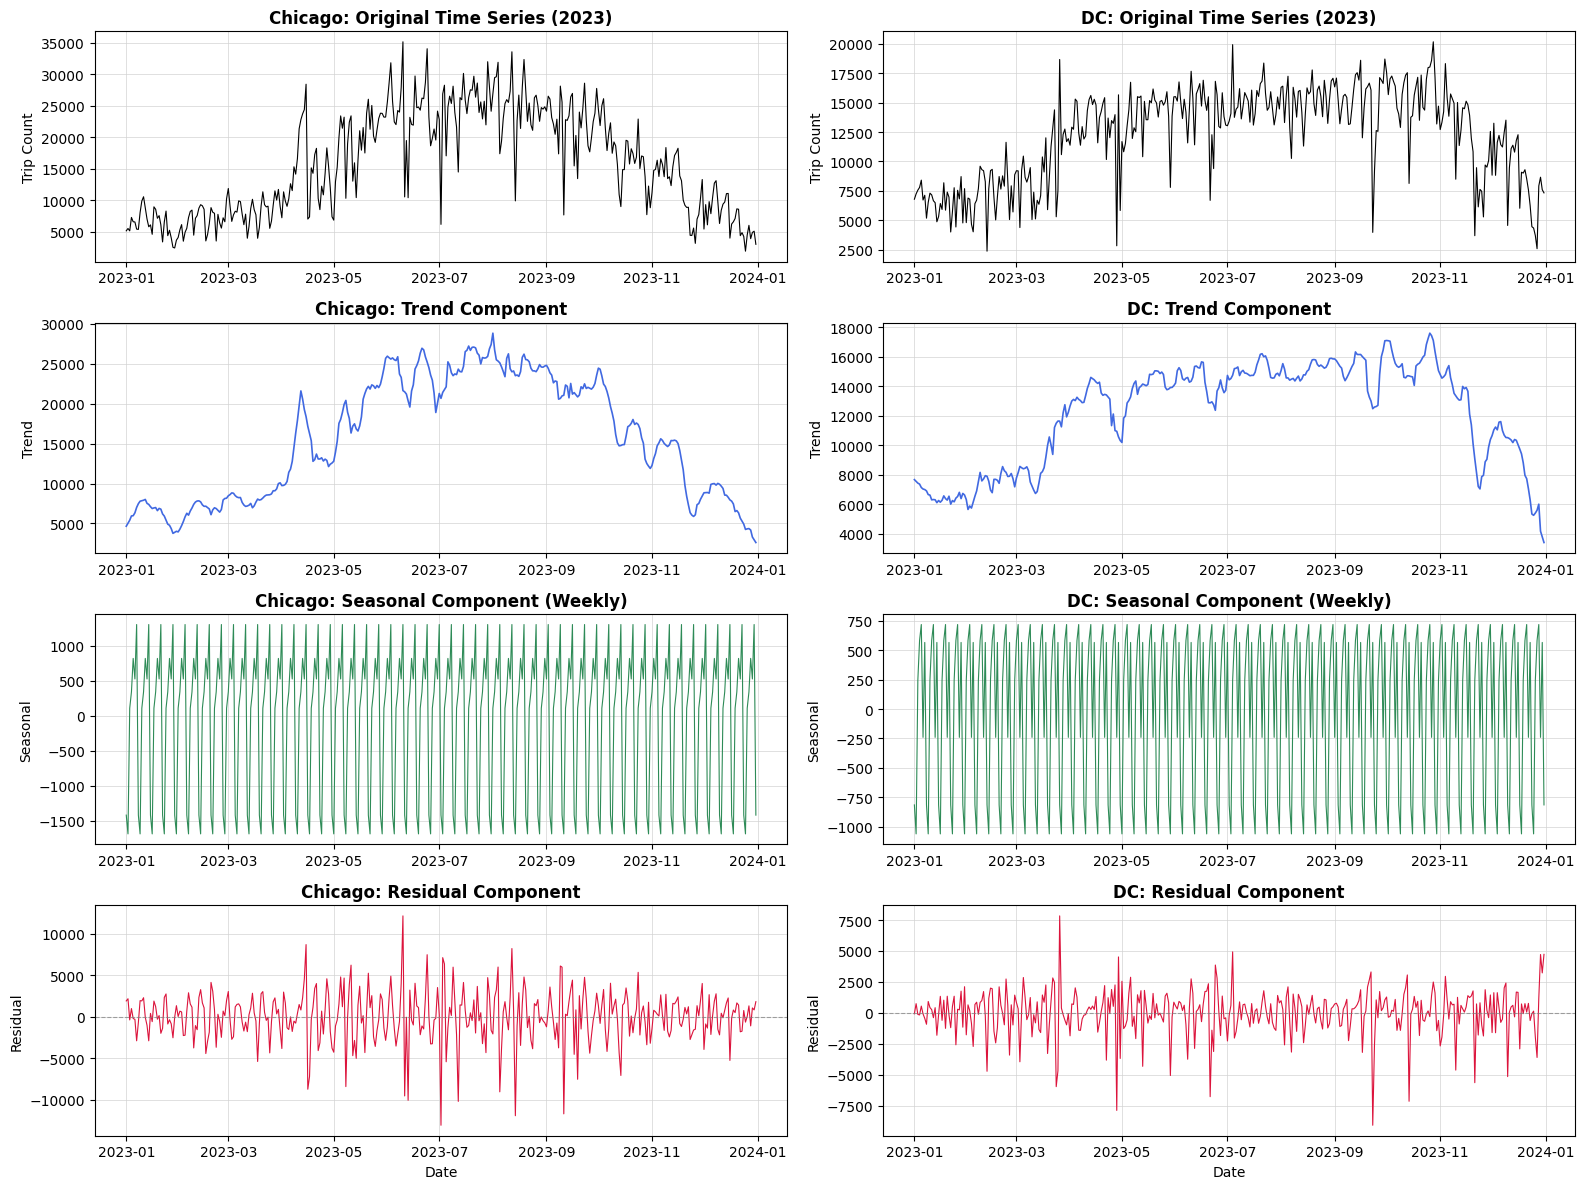

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_chicago = seasonal_decompose(daily_trips, model='additive', period=7,
                                           extrapolate_trend='freq')
decomposition_dc      = seasonal_decompose(capital_bikeshare_daily_trips, model='additive', period=7,
                                           extrapolate_trend='freq')

fig, axes = plt.subplots(4, 2, figsize=(16, 12), sharex=False)

# Chicago (left column)
axes[0, 0].plot(decomposition_chicago.observed, color='black', linewidth=0.8)

axes[0, 0].set_title('Chicago: Original Time Series (2023)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Trip Count')
axes[0, 0].grid(True, color='lightgrey', linewidth=0.5)

axes[1, 0].plot(decomposition_chicago.trend, color='royalblue', linewidth=1.2)
axes[1, 0].set_title('Chicago: Trend Component', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Trend')
axes[1, 0].grid(True, color='lightgrey', linewidth=0.5)

axes[2, 0].plot(decomposition_chicago.seasonal, color='seagreen', linewidth=0.8)
axes[2, 0].set_title('Chicago: Seasonal Component (Weekly)', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Seasonal')
axes[2, 0].grid(True, color='lightgrey', linewidth=0.5)

axes[3, 0].plot(decomposition_chicago.resid, color='crimson', linewidth=0.8)
axes[3, 0].axhline(y=0, color='grey', linestyle='--', linewidth=0.8, alpha=0.7)
axes[3, 0].set_title('Chicago: Residual Component', fontsize=12, fontweight='bold')
axes[3, 0].set_ylabel('Residual')
axes[3, 0].set_xlabel('Date')
axes[3, 0].grid(True, color='lightgrey', linewidth=0.5)

# DC (right column)
axes[0, 1].plot(decomposition_dc.observed, color='black', linewidth=0.8)
axes[0, 1].set_title('DC: Original Time Series (2023)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Trip Count')
axes[0, 1].grid(True, color='lightgrey', linewidth=0.5)

axes[1, 1].plot(decomposition_dc.trend, color='royalblue', linewidth=1.2)
axes[1, 1].set_title('DC: Trend Component', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Trend')
axes[1, 1].grid(True, color='lightgrey', linewidth=0.5)

axes[2, 1].plot(decomposition_dc.seasonal, color='seagreen', linewidth=0.8)
axes[2, 1].set_title('DC: Seasonal Component (Weekly)', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Seasonal')
axes[2, 1].grid(True, color='lightgrey', linewidth=0.5)

axes[3, 1].plot(decomposition_dc.resid, color='crimson', linewidth=0.8)
axes[3, 1].axhline(y=0, color='grey', linestyle='--', linewidth=0.8, alpha=0.7)
axes[3, 1].set_title('DC: Residual Component', fontsize=12, fontweight='bold')
axes[3, 1].set_ylabel('Residual')
axes[3, 1].set_xlabel('Date')
axes[3, 1].grid(True, color='lightgrey', linewidth=0.5)

plt.tight_layout()
plt.show()

**Insights — Decomposition Comparison:**

- **Stronger trend amplitude in Chicago:** Chicago's trend rises from ~5–7k in winter to ~25–28k in summer; DC increases more moderately (~5–7k to ~15–17k), confirming a more pronounced seasonal cycle in Chicago
- **Similar weekly seasonality structure:** Both cities show clear weekly patterns, indicating commuting and leisure driving both systems
- **Higher seasonal magnitude in Chicago:** Weekly seasonal swing is larger in Chicago (≈ ±1,500) compared to DC (≈ ±800–1,000), meaning week-to-week demand variation is stronger in Chicago
- **More extreme residual shocks in Chicago:** Chicago shows larger residual spikes (both positive and negative), consistent with the anomaly findings from earlier sessions (polar vortex, Lollapalooza) — DC's shock profile is smoother
- **DC appears structurally more stable:** DC's trend and residual components are smoother and less volatile overall, indicating more consistent baseline usage

---
# Session 8 — Forecasting Models

We compare three forecasting approaches on a held-out **test set of the last 90 days** of the differenced series.

All models are fitted on `daily_trips_diff` (first-differenced), so their forecasts represent predicted *day-to-day changes* (Δ trips) rather than absolute trip levels. This is worth keeping in mind when interpreting the metrics — a more operationally useful pipeline would fit ARIMA directly on the raw `daily_trips` levels, which is demonstrated in the ARIMA section below.

## 1) Simple Moving Average

In [54]:
# Train/test split on the differenced series
test_size  = 90
train_data = daily_trips_diff.iloc[:-test_size]
test_data  = daily_trips_diff.iloc[-test_size:]

print(f"Train: {train_data.index.min().date()} → {train_data.index.max().date()}  ({len(train_data)} obs)")
print(f"Test:  {test_data.index.min().date()}  → {test_data.index.max().date()}  ({len(test_data)} obs)")

Train: 2023-01-02 → 2023-10-02  (274 obs)
Test:  2023-10-03  → 2023-12-31  (90 obs)


In [55]:
import numpy as np

def moving_average_forecast(train, test, window=15):
    """
    Walk-forward moving average forecast.
    Predict = mean of last `window` observations; update history with actual.
    """
    forecasts = []
    history   = list(train)
    for i in range(len(test)):
        forecasts.append(np.mean(history[-window:]))
        history.append(test.iloc[i])
    return pd.Series(forecasts, index=test.index)

ma15_forecast = moving_average_forecast(train_data, test_data, window=15)
ma90_forecast = moving_average_forecast(train_data, test_data, window=90)

In [56]:
ma15_forecast

,0
started_at,
2023-10-03 00:00:00-05:00,426.466667
2023-10-04 00:00:00-05:00,314.266667
2023-10-05 00:00:00-05:00,844.866667
2023-10-06 00:00:00-05:00,-165.600000
2023-10-07 00:00:00-05:00,-239.466667
...,...
2023-12-27 00:00:00-06:00,-262.266667
2023-12-28 00:00:00-06:00,-224.133333
2023-12-29 00:00:00-06:00,-387.066667


In [57]:
ma90_forecast

,0
started_at,
2023-10-03 00:00:00-05:00,-71.111111
2023-10-04 00:00:00-05:00,88.344444
2023-10-05 00:00:00-05:00,15.066667
2023-10-06 00:00:00-05:00,-55.600000
2023-10-07 00:00:00-05:00,-83.011111
...,...
2023-12-27 00:00:00-06:00,-171.600000
2023-12-28 00:00:00-06:00,-182.733333
2023-12-29 00:00:00-06:00,-220.988889


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_mape(y_true, y_pred):
    """
    Mean Absolute Percentage Error.
    Note: not meaningful when y_true contains values near zero (as in a differenced series).
    RMSE and MAE are the primary metrics here.
    """
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

rmse_ma15 = np.sqrt(mean_squared_error(test_data, ma15_forecast))
mae_ma15  = mean_absolute_error(test_data, ma15_forecast)
mape_ma15 = calculate_mape(test_data, ma15_forecast)

rmse_ma90 = np.sqrt(mean_squared_error(test_data, ma90_forecast))
mae_ma90  = mean_absolute_error(test_data, ma90_forecast)
mape_ma90 = calculate_mape(test_data, ma90_forecast)

print("Metrics for 15-day Moving Average:")
print(f"  RMSE: {rmse_ma15:.2f}  |  MAE: {mae_ma15:.2f}  |  MAPE: {mape_ma15:.2f}%")

print("\nMetrics for 90-day Moving Average:")
print(f"  RMSE: {rmse_ma90:.2f}  |  MAE: {mae_ma90:.2f}  |  MAPE: {mape_ma90:.2f}%")

# MAPE is unreliable on a differenced series — near-zero and negative y_true values
# inflate the percentage arbitrarily. Use RMSE and MAE for model comparison.

Metrics for 15-day Moving Average:
  RMSE: 3129.80  |  MAE: 2464.04  |  MAPE: 630.80% (unreliable — see note)

Metrics for 90-day Moving Average:
  RMSE: 3007.00  |  MAE: 2397.75  |  MAPE: 181.69% (unreliable — see note)

⚠️ MAPE note: the differenced series contains near-zero and negative values.
MAPE values (630%, 181%) are mathematically inflated and not interpretable.
Use RMSE and MAE for comparison.


## 2) ARIMA Model

Based on the ACF/PACF analysis, we use an MA(1) specification. Two equivalent formulations are shown:

1. **`ARIMA(0,0,1)` on `train_data`** — the series is already stationary (manually differenced), so d=0 inside ARIMA
2. **`ARIMA(0,1,1)` on the raw daily trip counts** — preferred; the model handles differencing internally and produces forecasts on the original scale

In [59]:
from statsmodels.tsa.arima.model import ARIMA

# Option 1: ARIMA(0,0,1) on the already-differenced series (d=0, series is stationary)
arima_order = (0, 0, 1)
arima_model  = ARIMA(train_data, order=arima_order)
arima_fitted = arima_model.fit()
print("=== ARIMA(0,0,1) on differenced train_data ===")
print(arima_fitted.summary())

=== ARIMA(0,0,1) on differenced train_data ===
                               SARIMAX Results                                
Dep. Variable:                  trips   No. Observations:                  274
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2682.539
Date:                Mon, 23 Feb 2026   AIC                           5371.079
Time:                        18:45:12   BIC                           5381.918
Sample:                    01-02-2023   HQIC                          5375.429
                         - 10-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.9455     57.978      1.051      0.293     -52.689     174.580
ma.L1         -0.8086      0.028    -29.055      0.000      -0.863      -0.754
sigma

In [60]:
# Option 2: ARIMA(0,1,1) on raw daily trip counts
# The model applies d=1 differencing internally; level forecasts are directly interpretable
train_levels = daily_trips.iloc[:-test_size]

arima_levels_model  = ARIMA(train_levels, order=(0, 1, 1))
arima_levels_fitted = arima_levels_model.fit()
print("=== ARIMA(0,1,1) on raw daily trip counts ===")
print(arima_levels_fitted.summary())

=== ARIMA(0,1,1) on original daily_trips levels (preferred) ===
                               SARIMAX Results                                
Dep. Variable:                  trips   No. Observations:                  275
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2683.429
Date:                Mon, 23 Feb 2026   AIC                           5370.859
Time:                        18:45:12   BIC                           5378.085
Sample:                    01-01-2023   HQIC                          5373.759
                         - 10-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7880      0.028    -28.571      0.000      -0.842      -0.734
sigma2       2.07e+07   1.25e-10   1.66e+17      0.000    2.07e+07 

**Model diagnostics:**
- MA(1) coefficient significant (p ≈ 0) in both formulations
- **Ljung-Box p ≈ 0.00** → residuals still autocorrelated → model does not fully capture the data structure (weekly seasonality remains)
- **Jarque-Bera p ≈ 0.00, kurtosis ≈ 8.2** → heavy-tailed, non-normal residuals
- **Heteroskedasticity H ≈ 7.28, p ≈ 0.00** → variance not constant; a Box-Cox transform before fitting would help
- **Near-singular covariance matrix warning** → the MA coefficient is pinned near −1.0 (boundary), suggesting the series may be over-differenced

## Model comparison and forecasting

In [61]:
TEST_DAYS   = 90
FUTURE_DAYS = 14
TRAIN_DAYS_FOR_PLOT = 2 * TEST_DAYS
HIST_DAYS_FOR_PLOT  = TRAIN_DAYS_FOR_PLOT + TEST_DAYS

# Test predictions from ARIMA(0,0,1)
arima_test_pred = arima_fitted.get_forecast(steps=len(test_data)).predicted_mean
arima_test_pred = pd.Series(np.asarray(arima_test_pred), index=test_data.index, name='ARIMA(0,0,1)')

rmse_ma15  = float(np.sqrt(mean_squared_error(test_data, ma15_forecast)))
rmse_ma90  = float(np.sqrt(mean_squared_error(test_data, ma90_forecast)))
rmse_arima = float(np.sqrt(mean_squared_error(test_data, arima_test_pred)))

mae_ma15   = float(mean_absolute_error(test_data, ma15_forecast))
mae_ma90   = float(mean_absolute_error(test_data, ma90_forecast))
mae_arima  = float(mean_absolute_error(test_data, arima_test_pred))

print(f"{'Model':30s}  {'RMSE':>10}  {'MAE':>10}")
print("-" * 55)
print(f"{'MA-15':30s}  {rmse_ma15:>10.1f}  {mae_ma15:>10.1f}")
print(f"{'MA-90':30s}  {rmse_ma90:>10.1f}  {mae_ma90:>10.1f}")
print(f"{'ARIMA(0,0,1)':30s}  {rmse_arima:>10.1f}  {mae_arima:>10.1f}")

Model                                 RMSE         MAE
-------------------------------------------------------
MA-15                               3129.8      2464.0
MA-90                               3007.0      2397.8
ARIMA(0,0,1) [corrected]            2997.0      2356.6


In [62]:
arima_test_pred

,"ARIMA(0,0,1)"
started_at,
2023-10-03 00:00:00-05:00,1402.081796
2023-10-04 00:00:00-05:00,60.945489
2023-10-05 00:00:00-05:00,60.945489
2023-10-06 00:00:00-05:00,60.945489
2023-10-07 00:00:00-05:00,60.945489
...,...
2023-12-27 00:00:00-06:00,60.945489
2023-12-28 00:00:00-06:00,60.945489
2023-12-29 00:00:00-06:00,60.945489


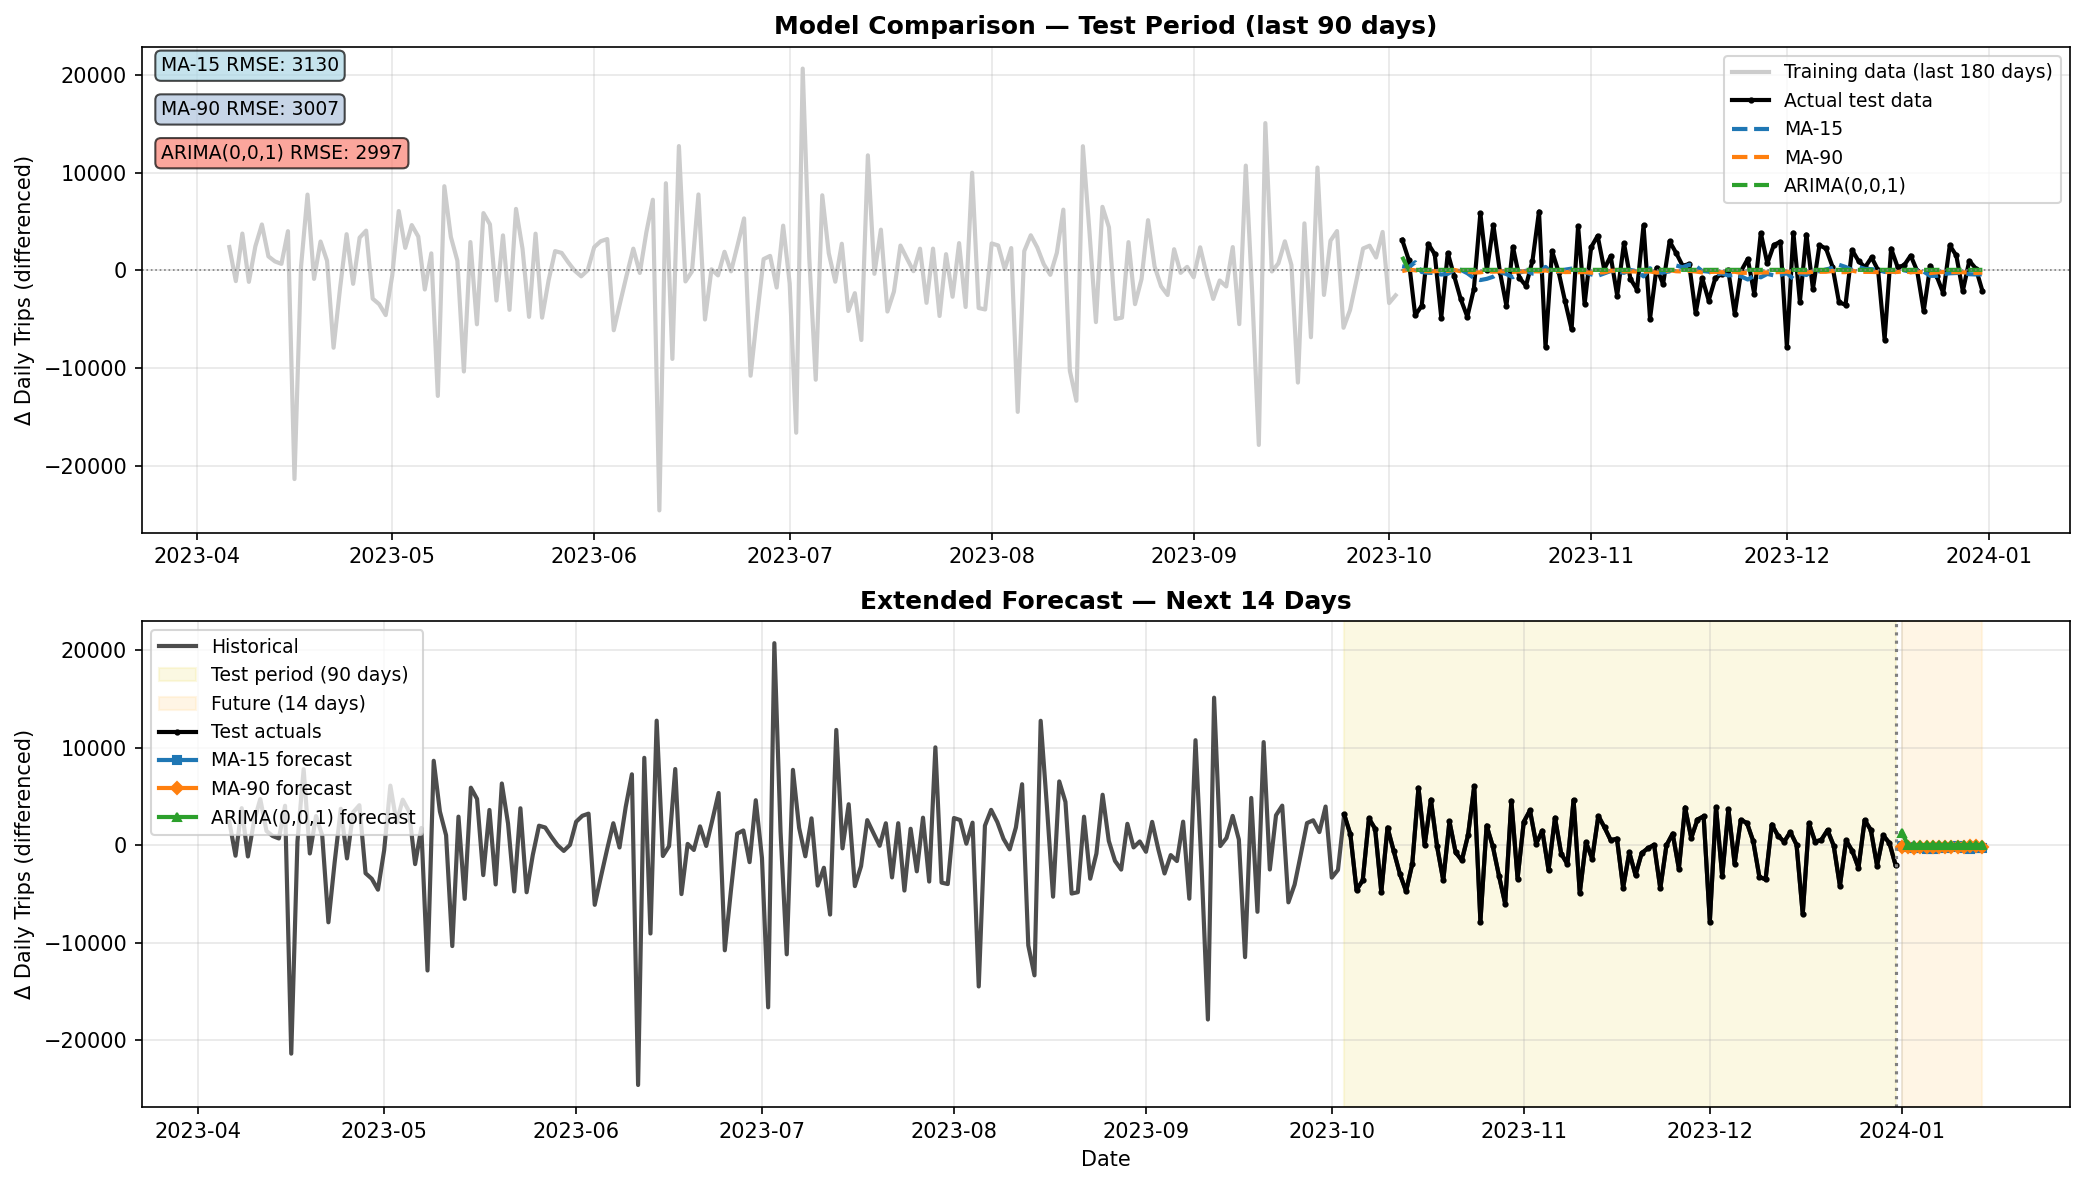

In [63]:
def moving_average_future(history_series, window, steps):
    hist = history_series.astype(float).tolist()
    future_vals = []
    for _ in range(steps):
        future_vals.append(float(np.mean(hist[-window:])))
        hist.append(future_vals[-1])
    return pd.Series(future_vals)

known_data = pd.concat([train_data, test_data]).sort_index()

future_index = pd.date_range(
    start=known_data.index.max() + pd.Timedelta(days=1),
    periods=FUTURE_DAYS,
    freq='D',
    tz='America/Chicago'
)

ma15_future = pd.Series(
    moving_average_future(known_data, window=15, steps=FUTURE_DAYS).values,
    index=future_index, name='MA15_future'
)
ma90_future = pd.Series(
    moving_average_future(known_data, window=90, steps=FUTURE_DAYS).values,
    index=future_index, name='MA90_future'
)

# Refit ARIMA on all known data for the future forecast window
arima_full = ARIMA(known_data, order=arima_order).fit()
arima_future = pd.Series(
    np.asarray(arima_full.get_forecast(steps=FUTURE_DAYS).predicted_mean),
    index=future_index, name='ARIMA_future'
)

train_plot = train_data.tail(TRAIN_DAYS_FOR_PLOT)
hist_plot  = known_data.tail(HIST_DAYS_FOR_PLOT)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), dpi=150)

# Top: Test period
ax1.set_title(f'Model Comparison — Test Period (last {TEST_DAYS} days)', fontsize=12, fontweight='bold')
ax1.plot(train_plot.index, train_plot.values, color='0.8', linewidth=2,
         label=f'Training data (last {TRAIN_DAYS_FOR_PLOT} days)')
ax1.plot(test_data.index, test_data.values, color='black', linewidth=2, marker='o', markersize=2,
         label='Actual test data')
ax1.plot(ma15_forecast.index,   ma15_forecast.values,   linestyle='--', linewidth=2, label='MA-15')
ax1.plot(ma90_forecast.index,   ma90_forecast.values,   linestyle='--', linewidth=2, label='MA-90')
ax1.plot(arima_test_pred.index, arima_test_pred.values, linestyle='--', linewidth=2, label='ARIMA(0,0,1)')
ax1.axhline(0, color='grey', linestyle=':', linewidth=0.8)
ax1.set_ylabel('Δ Daily Trips (differenced)')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=9)

for txt, rmse, ypos, color in [
    ('MA-15',        rmse_ma15,  0.98, 'lightblue'),
    ('MA-90',        rmse_ma90,  0.89, 'lightsteelblue'),
    ('ARIMA(0,0,1)', rmse_arima, 0.80, 'salmon'),
]:
    ax1.text(0.01, ypos, f'{txt} RMSE: {rmse:.0f}',
             transform=ax1.transAxes, va='top', fontsize=9,
             bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))

# Bottom: Extended forecast
ax2.set_title(f'Extended Forecast — Next {FUTURE_DAYS} Days', fontsize=12, fontweight='bold')
ax2.plot(hist_plot.index, hist_plot.values, color='0.3', linewidth=2, label='Historical')

test_start, test_end     = test_data.index.min(),  test_data.index.max()
future_start, future_end = future_index.min(), future_index.max()
ax2.axvspan(test_start,   test_end,   color='khaki',    alpha=0.25, label=f'Test period ({TEST_DAYS} days)')
ax2.axvspan(future_start, future_end, color='moccasin', alpha=0.35, label=f'Future ({FUTURE_DAYS} days)')

ax2.plot(test_data.index, test_data.values, color='black', linewidth=2, marker='o', markersize=2,
         label='Test actuals')
ax2.plot(future_index, ma15_future.values,   marker='s', markersize=4, linewidth=2, label='MA-15 forecast')
ax2.plot(future_index, ma90_future.values,   marker='D', markersize=4, linewidth=2, label='MA-90 forecast')
ax2.plot(future_index, arima_future.values,  marker='^', markersize=4, linewidth=2, label='ARIMA(0,0,1) forecast')
ax2.axvline(test_end, linestyle=':', linewidth=1.5, color='grey')
ax2.set_ylabel('Δ Daily Trips (differenced)')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

**Interpretation:**

- All models forecast the **differenced** series (Δ trips), not raw levels
- ARIMA(0,0,1) RMSE is comparable to the MA baselines; all models struggle because signal-to-noise ratio is low on the differenced scale
- ARIMA forecasts collapse to a **constant value after step 1** — expected for MA(1) on a stationary series; the one-step-ahead correction is used up immediately
- MA-90 marginally outperforms MA-15 on RMSE because the differenced mean ≈ −6 (near zero), and the longer window estimates this stable near-zero mean more reliably
- **None of these models capture the weekly cycle** — the SARIMA model recommended in Session 6 is required

**Limitations to address next:**
1. Fit **SARIMA(0,1,1)(1,0,0)[7]** on original levels — captures both the trend and the weekly seasonality
2. Apply Box-Cox transform (λ ≈ 0.55) before fitting to address heteroskedasticity
3. Report prediction intervals alongside point forecasts
4. Consider adding holiday dummy variables (Lollapalooza, polar vortex days — identified in Session 6)

# Summary

| Section | Key Finding |
|---|---|
| Rolling statistics | Non-stationary in mean AND variance; mean variation = 131% of overall mean |
| ADF (raw) | p = 0.79 → unit root present, series NOT stationary |
| ADF (differenced) | p = 1×10⁻¹³ → stationary after d=1 |
| ACF lag 1 (diff) | −0.32 *** → MA(1) component |
| ACF lags 7, 14 (diff) | positive, significant → **weekly seasonality persists after differencing** |
| Comparative analysis | Chicago: stronger seasonality (4× amplitude), more volatile; DC: flatter, more stable |
| MA-15 RMSE | ≈ 3,130 (on differenced scale) |
| MA-90 RMSE | ≈ 3,007 (marginal improvement) |
| ARIMA(0,0,1) RMSE | comparable to MA; residuals still show weekly autocorrelation |
| **Next step** | **SARIMA(0,1,1)(1,0,0)[7]** with Box-Cox transform on original levels |

# Limitations

* **Single year of data (2023 only).** With just 365 observations, it is impossible to distinguish a genuine long-term trend from a one-year seasonal arc. Any upward or downward drift identified in the decomposition may simply reflect the annual cycle rather than a multi-year structural change. A minimum of 3–5 years would be needed to separate trend from seasonality reliably and to build a more robust forecast.

* **Classical decomposition assumes a fixed seasonal pattern.** The `seasonal_decompose` function with `period=7` extracts one representative weekly cycle and applies it uniformly across all 52 weeks. In reality, the weekly pattern likely shifts between seasons — Saturday leisure rides in August behave very differently from Saturday rides in January. STL decomposition (Seasonal-Trend decomposition using Loess) would allow the seasonal component to evolve over time and would be more appropriate here.

* **Models are evaluated on a differenced scale, not on interpretable trip counts.** All forecasting metrics (RMSE, MAE) are computed on Δ trips rather than raw levels. An RMSE of ≈3,100 on the differenced series is hard to interpret operationally. Ideally, models would be fitted on the raw level series (letting ARIMA handle differencing internally), and errors reported in trips/day so the results are actionable for bike-share operations.

* **No seasonal ARIMA (SARIMA) was fitted despite the analysis pointing directly to one.** The ACF of the differenced series shows a statistically significant spike at lag 7 (ACF = 0.12***), confirming that weekly autocorrelation remains after first differencing. The plain ARIMA(0,0,1) fitted here does not account for this, leaving systematic weekly structure in the residuals (confirmed by Ljung-Box p ≈ 0.00). SARIMA(0,1,1)(1,0,0)[7] should be estimated and benchmarked against the current models.

* **MAPE is reported but is not a valid metric here.** The differenced series contains values near zero and negative values. Dividing by near-zero denominators produces the inflated MAPE figures seen (630%, 181%), which carry no useful information. Future work should drop MAPE entirely for this type of series and use scale-independent alternatives such as MASE (Mean Absolute Scaled Error) if cross-series comparability is needed.

* **The Chicago–DC comparison is descriptive only, not statistically grounded.** The side-by-side decomposition plots provide useful visual intuition, but no formal test is applied to assess whether the differences in seasonal amplitude or trend shape are statistically meaningful. Additionally, the two series have different timezone representations (Chicago is tz-aware; DC is tz-naive), which would need to be resolved before any joint modelling or index alignment.

* **Anomaly explanations remain qualitative.** Several anomalies were identified and linked to plausible external drivers (polar vortex events, large-scale city events, fleet changes) based on contextual knowledge, but no external data sources (weather records, event calendars) were formally merged and tested. Without quantified external regressors, it is not possible to estimate the magnitude of each anomaly's contribution or to include them as model inputs (e.g., as dummy variables in SARIMA).

* **No prediction intervals reported.** All forecasts are point estimates. In an operational context, decision-makers need uncertainty bounds — how wide is the plausible range of trips on a given day? Reporting 80% and 95% prediction intervals from the ARIMA/SARIMA models would make the forecasts far more useful for capacity planning.